In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Import contents of pacakge
import posfai2_fixed as my

In [2]:
# Specify sequence and ohe_spec_str
alphabet = 'ACGT'
alpha = len(alphabet)
L = 2
seq = 'TT'
n_order = 2
n_adj = 2
L = len(seq)

# Create spec string
ohe_spec_str = my.get_ohe_spec_str(L, n_order=n_order, n_adj=n_adj)

print(f'seq: {seq}')
print(f'alphabet: {alphabet}')
print(f'alpha: {alpha}')

# Get one-hot encoding of x
x_ohe = my.seq_to_x_ohe(seq, ohe_spec_str, alphabet=alphabet, fix=True).todense()
print(f'x_ohe.shape: {x_ohe.shape}')

M = len(x_ohe)
print(f'M: {M}')

# Get transformation matrix
T, T_inv = my._ohe_spec_to_T(ohe_spec_str, alpha=alpha, compute_inv=False)
print(f'T.shape: {T.shape}')

# Get reordering matrix
B, B_inv = my._ohe_spec_to_B(ohe_spec_str, alpha=alpha)
print(f'B.shape: {B.shape}')

# Get thinning matrix
A, A_inv = my._get_thinning_matrix(ohe_spec_str, alpha=alpha, fix=False)
print(f'A.shape: {A.shape}')

# Get distilling matrix
D, D_inv, gamma = my._get_distilling_matrix(ohe_spec_str, alpha=alpha, fix=False)
print(f'D.shape: {D.shape}')
print(f'gamma: {gamma}')

# Get vector to test thinning matrix
x_test = my.get_x_to_test_thinning_matrix(ohe_spec_str, alpha=alpha)
print(f'x_test.shape: {x_test.shape}')

seq: TT
alphabet: ACGT
alpha: 4
x_ohe.shape: (25, 1)
M: 25
T.shape: (25, 25)
B.shape: (25, 25)
A.shape: (25, 25)
D.shape: (25, 25)
gamma: 9
x_test.shape: (25,)


.+.+0+.+1+.+1+0+0x1


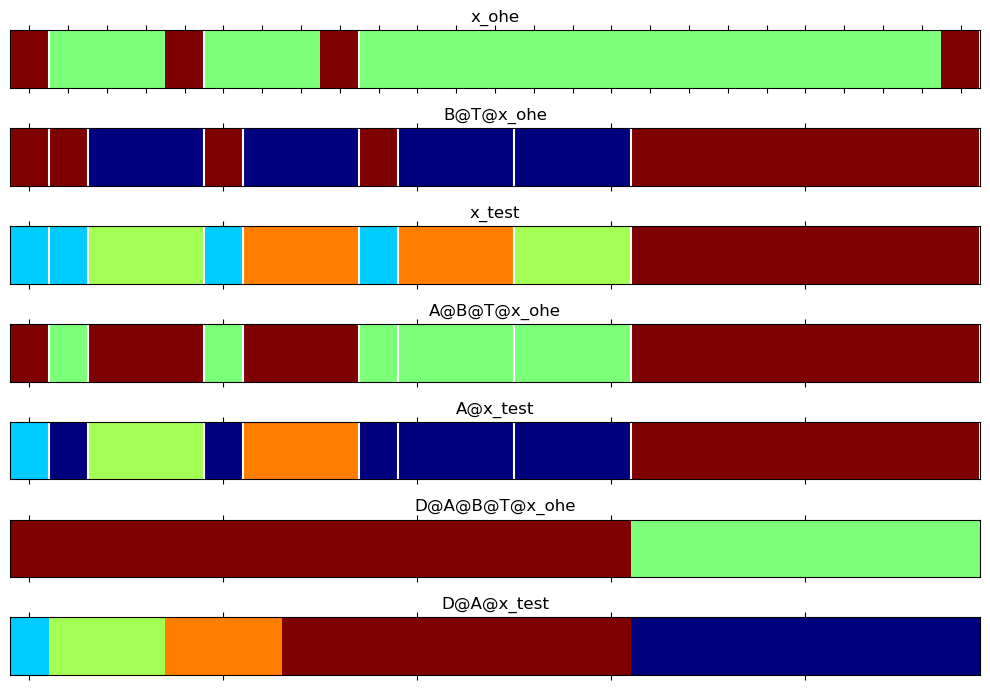

In [3]:
# Make figure
fig, axs = plt.subplots(7,1,figsize=[10,7])

# Get sim_spec
sim_spec_str = my.ohe_to_sim_spec(ohe_spec_str)

# Compute ohe vlines
ohe_vlines = []
parts = ohe_spec_str.split('+')
offset = 0
ohe_vlines.append(offset-.5)
for part in parts:
    if part=='.':
        m=1
    else:
        num_poss = len(part.split('x'))
        m=alpha**(num_poss)
    offset += m
    ohe_vlines.append(offset-.5)

# Compute vline xs
sim_vlines = []
parts = sim_spec_str.split('+')
offset = 0
sim_vlines.append(offset-.5)
for part in parts:
    if part=='.':
        m=1
    else:
        num_poss = len(part.split('x'))
        m=(alpha-1)**(num_poss)
    offset += m
    sim_vlines.append(offset-.5)

#####

# Show x_ohe
ax = axs[0]
ax.matshow(np.mat(x_ohe).T, vmin=-1, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('x_ohe')
ax.set_aspect('auto')
ax.set_xticks(range(M))
ax.set_xticklabels([])
for x in ohe_vlines:
    ax.axvline(x, color='w')

# Show T@x_ohe
ax = axs[1]
ax.matshow(np.mat(B@T@x_ohe).T, vmin=-1, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('B@T@x_ohe')
ax.set_aspect('auto')
#ax.set_xticks(range(M))
ax.set_xticklabels([])
for x in sim_vlines:
    ax.axvline(x, color='w')

# Show x_test
ax = axs[2]
ax.matshow(np.mat(x_test), vmin=0, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('x_test')
ax.set_aspect('auto')
#ax.set_xticks(range(M))
ax.set_xticklabels([])
for x in sim_vlines:
    ax.axvline(x, color='w')

# Show A@T@x_ohe
ax = axs[3]
ax.matshow(np.abs(np.mat(A@B@T@x_ohe)).T, vmin=-1, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('A@B@T@x_ohe')
ax.set_aspect('auto')
#ax.set_xticks(range(M))
ax.set_xticklabels([])
for x in sim_vlines:
    ax.axvline(x, color='w')

# Show A@x_test
ax = axs[4]
ax.matshow(np.mat(A@x_test), vmin=0, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('A@x_test')
ax.set_aspect('auto')
#ax.set_xticks(range(M))
ax.set_xticklabels([])
for x in sim_vlines:
    ax.axvline(x, color='w')

# Show D@A@T@x_ohe
ax = axs[5]
ax.matshow(np.abs(np.mat(D@A@B@T@x_ohe)).T, vmin=-1, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('D@A@B@T@x_ohe')
ax.set_aspect('auto')
#ax.set_xticks(range(M))
ax.set_xticklabels([])

# Show A@x_test
ax = axs[6]
ax.matshow(np.mat(D@A@x_test), vmin=0, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('D@A@x_test')
ax.set_aspect('auto')
#ax.set_xticks(range(M))
ax.set_xticklabels([])

plt.tight_layout()
print(sim_spec_str)



In [4]:
######

# Test A@B@T@x_ohe == x_dist for all possible sequences
all_seqs = my.make_random_seqs(L, num_seqs=100)
num_matches = 0
for seq in all_seqs:
    x_ohe = my.seq_to_x_ohe(seq, ohe_spec_str, alphabet=alphabet, fix=True).todense()
    desired_BTx = np.array(my.seq_to_desired_BTx(seq, ohe_spec_str, alphabet=alphabet, fix=True), dtype=np.int64).reshape((M,1))
    match = np.all(B@T@x_ohe == desired_BTx)
    if match:
        num_matches += 1
    else:
        print(f'mismatch for {seq}: B@T@x_ohe=\n{(B@T@x_ohe).T};\ndesired_BTx=\n{desired_BTx.T}')
        break;
print(f'B@T@x_ohe == x_dist for {num_matches}/{len(all_seqs)} seqs')

# Test that matrices invert properly
C = A@B@T
C_inv = T_inv@B_inv@A_inv
print('C@C_inv == I:', np.allclose((C@C_inv).todense(), np.eye(M)))

# Check gauge basis
E = D@A@B@T
gauge_basis = E[(M-gamma):,:].T
all_seqs = my.make_all_seqs(L)
x_ohes = np.hstack([my.seq_to_x_ohe(seq, ohe_spec_str, alphabet=alphabet, fix=True).todense() for seq in all_seqs])
np.allclose((gauge_basis.T)@x_ohes, 0)
print('Unique elements of gauge basis', np.unique(gauge_basis.data))

B@T@x_ohe == x_dist for 100/100 seqs


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [ ]:
# Test A@B@T@x_ohe == x_dist for all possible sequences 
seqs = my.make_random_seqs(L, num_seqs=1000)
num_matches = 0
for seq in seqs:
    x_ohe = my.seq_to_x_ohe(seq, ohe_spec_str, alphabet=alphabet).todense()
    desired_BTx = np.array(my.seq_to_desired_BTx(seq, ohe_spec_str, alphabet=alphabet, fix=True), dtype=np.int64).reshape((M,1))
    match = np.all(B@T@x_ohe == desired_BTx)
    
    if match:
        num_matches += 1
    else:
        pass;
        #print(f'mismatch for {seq}')
print(f'B@T@x_ohe == x_dist for {num_matches}/{len(seqs)} seqs')

# Test that matrices invert properly
C = A@B@T
C_inv = T_inv@B_inv@A_inv
print('C@C_inv == I:', np.allclose((C@C_inv).todense(), np.eye(M)))

# Check gauge basis
E = D@A@B@T
gauge_basis = E[-gamma:,:].T
seqs = my.make_random_seqs(L, num_seqs=100)
x_ohes = np.hstack([my.seq_to_x_ohe(seq, ohe_spec_str, alphabet=alphabet).todense() for seq in seqs])
print(f'All {gamma:,d} gauge vectors are orthogonal to embeddings of all {x_ohes.shape[1]:,d} random seqs:', np.allclose((gauge_basis.T)@x_ohes, 0))
print('Unique elements of gauge basis', np.unique(gauge_basis.data))

In [ ]:
ohe_spec_str